In [2]:
%load_ext autoreload
%autoreload 2

In [42]:
import torch
import pandas as pd
from torch import nn
from pathlib import Path
import json
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    window_session, 
    pad_for_windowing, 
    evaluate_loop, 
    plot_and_save_cm, 
    read_and_window_session,
    read_session
)
from lib.models import  MLP
from tqdm import tqdm
import plotly.express as px

In [3]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")
WINSIZE = 101
DEVICE = 'cuda'

In [21]:
train_sessions = [25, 67]
test_sessions = [58, 62]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [27]:
model = MLP(100, WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:25<00:00,  2.66s/it]


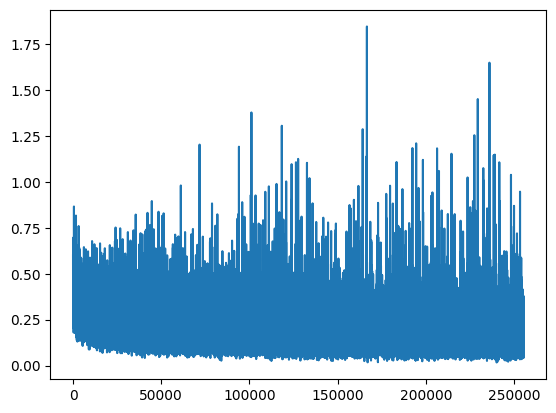

In [30]:
trainloader = DataLoader(TensorDataset(X,y), batch_size=64, shuffle=True)

losses = []
for i in tqdm(range(100)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(DEVICE), yi.to(DEVICE)
        logits = model(Xi)
        loss = criterion(logits, yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

plt.plot(losses)

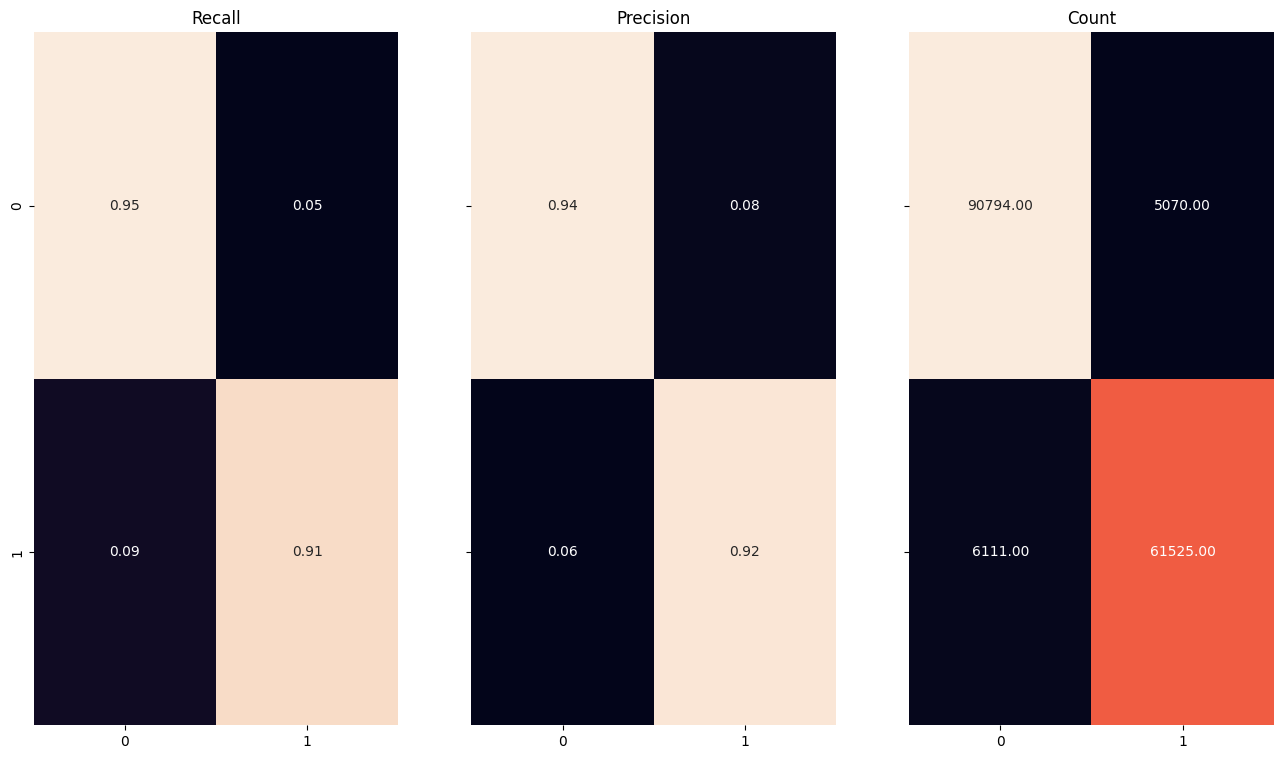

0.16481751256922617 0.9238681582701403 0.9096487077887515 0.9167032950659683


In [31]:
testloader = DataLoader(TensorDataset(X,y), batch_size=64)

y_true, y_pred, loss, prec, recall, f1_score = evaluate_loop(model, criterion, testloader, DEVICE, metrics=True)
plot_and_save_cm(y_true, y_pred)
print(loss, prec, recall, f1_score)

In [63]:
test_session = test_sessions[1]

test_to_plot = read_session(test_session, raw_dir)
Xtest, ytest = read_and_window_session(test_session, WINSIZE, raw_dir, label_dir)
y_true, y_pred, loss, prec, recall, f1_score = evaluate_loop(
    model, 
    criterion, 
    DataLoader(TensorDataset(Xtest, ytest), batch_size=64), 
    DEVICE, 
    metrics=True
)
print(loss, prec, recall, f1_score)

test_to_plot['y_true'] = y_true
test_to_plot['y_pred'] = y_pred * 2

fig = px.line(test_to_plot[::5], x=test_to_plot.index[::5], y=['x_acc','y_acc','z_acc', 'y_true', 'y_pred'])
fig.show(renderer='browser')

0.16481751256922617 0.9238681582701403 0.9096487077887515 0.9167032950659683


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/mmazeem/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/mmazeem/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Opening in existing browser session.
